# CatBoost Model and Model Comparison

This notebook implements an end-to-end pipeline to:
1. Ingest and preprocess the flight prices dataset.
2. Engineer features (including converting ISO 8601 travel durations to minutes,
   extracting day-of-week, month, and date difference features).
3. Train a baseline predictor, a Linear Regression model, a Random Forest Regressor,
   and a CatBoost regressor.
4. Compare their performance (using Mean Squared Error) on the training and test sets.

## Section 1: Setup and Data Ingestion

Install required packages, download the dataset from Kaggle, unzip it, and create a Spark session.

In [ ]:
# Install necessary packages (uncomment if running for the first time)
# !pip install kaggle pyspark catboost

In [ ]:
# Download and unzip the dataset (uncomment if running for the first time)
!kaggle datasets download -d dilwong/flightprices
!unzip -n flightprices.zip

Dataset URL: https://www.kaggle.com/datasets/dilwong/flightprices
License(s): Attribution 4.0 International (CC BY 4.0)
flightprices.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  flightprices.zip


In [ ]:
# Import standard libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import PySpark modules
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
import pyspark.sql.functions as F

# Stop any existing SparkContext and initialize a new one
try:
    sc.stop()
except Exception as e:
    pass
sc = SparkContext()
sqlContext = SQLContext(sc)
ss = SparkSession.builder.getOrCreate()

# Read the CSV file into a Spark DataFrame
df = sqlContext.read.csv('itineraries.csv', header=True)
print("Sample of raw data:")
df.show(5)

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Sample of raw data:
+--------------------+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+-------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode|segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|segmentsDuration

## Section 2: Feature Engineering

Define a UDF to convert the travel duration (e.g., 'PT2H29M') into minutes.
Extract additional features: day-of-week (DOW), month-of-year (MOY), date difference between flight and search dates (DTF).
Select numerical and categorical features.

In [ ]:
# Define UDF to process travel duration strings and convert them to minutes
def tD_proc(entry):
    # Remove 'P' and 'T' characters
    wo_PT = ''.join(re.split('[PT]', entry))
    # Split based on days, hours, and minutes
    daysplit = re.split('D', wo_PT)
    hoursplit = re.split('H', daysplit[-1])
    minsplit = re.split('M', hoursplit[-1])
    totalmins = 0
    try:
        totalmins += 24 * 60 * int(daysplit[0])
    except:
        pass
    try:
        totalmins += 60 * int(hoursplit[0])
    except:
        pass
    try:
        totalmins += int(minsplit[0])
    except:
        pass
    return totalmins

# Register the UDF with Spark
tD_p = F.udf(lambda x: tD_proc(x))

# Define lists of features
num_feats = ['elapsedDays', 'totalTravelDistance', 'seatsRemaining']
cat_feats = ['startingAirport', 'destinationAirport', 'isBasicEconomy', 'isNonstop']
targets = ['baseFare', 'totalFare']

# Extract features from the DataFrame and cast numerical columns to float.
# Also extract date-based features: DOW, MOY, DTF; and convert travelDuration using our UDF.
fdf = df.select(
    *[df[f].cast('float') for f in num_feats + targets],
    *cat_feats,
    F.dayofweek(df['flightDate']).alias('DOW'),
    F.month(df['flightDate']).alias('MOY'),
    F.datediff(df['flightDate'], df['searchDate']).alias('DTF'),
    tD_p('travelDuration').alias('tD_p').cast('float')
)
print("Data after feature extraction:")
fdf.show(5)

Data after feature extraction:
+-----------+-------------------+--------------+--------+---------+---------------+------------------+--------------+---------+---+---+---+-----+
|elapsedDays|totalTravelDistance|seatsRemaining|baseFare|totalFare|startingAirport|destinationAirport|isBasicEconomy|isNonstop|DOW|MOY|DTF| tD_p|
+-----------+-------------------+--------------+--------+---------+---------------+------------------+--------------+---------+---+---+---+-----+
|        0.0|              947.0|           9.0|  217.67|    248.6|            ATL|               BOS|         False|     True|  1|  4|  1|149.0|
|        0.0|              947.0|           4.0|  217.67|    248.6|            ATL|               BOS|         False|     True|  1|  4|  1|150.0|
|        0.0|              947.0|           9.0|  217.67|    248.6|            ATL|               BOS|         False|     True|  1|  4|  1|150.0|
|        0.0|              947.0|           8.0|  217.67|    248.6|            ATL|          

## Section 3: Preprocessing Pipeline and Train-Test Split

Build an ML pipeline that:
- Imputes missing values in numerical features (using the median),
- Encodes categorical features (including the extracted DOW and MOY) with StringIndexer and OneHotEncoder,
- Assembles all features into a single feature vector.

Then, split the data into training (75%) and test (25%) sets.

In [ ]:
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
import pyspark.sql.functions as F

# Stop any existing SparkContext.
try:
    sc.stop()
except Exception:
    pass

# Reinitialize SparkSession with increased memory and additional configurations.
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.driver.memory", "200g") \
    .config("spark.executor.memory", "200g") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "100g") \
    .getOrCreate()
sqlContext = SQLContext(spark)

# Re-read the dataset.
df = sqlContext.read.csv('itineraries.csv', header=True)

# Define feature lists.
num_feats = ['elapsedDays', 'totalTravelDistance', 'seatsRemaining']
cat_feats = ['startingAirport', 'destinationAirport', 'isBasicEconomy', 'isNonstop']
targets = ['baseFare', 'totalFare']

# Assume the UDF tD_p (for processing travelDuration) is already defined.
# Create a feature DataFrame by extracting and casting necessary columns,
# including date-based features and processed travel duration.
fdf = df.select(
    *[df[f].cast('float') for f in num_feats + targets],
    *cat_feats,
    F.dayofweek(df['flightDate']).alias('DOW'),
    F.month(df['flightDate']).alias('MOY'),
    F.datediff(df['flightDate'], df['searchDate']).alias('DTF'),
    tD_p('travelDuration').alias('tD_p').cast('float')
)

# Repartition the DataFrame to distribute the load.
fdf = fdf.repartition(1000)

print("Total rows in fdf:", fdf.count())

# Extend categorical features to include DOW and MOY.
cat_feats_extended = cat_feats + ['DOW', 'MOY']
# Numeric features to impute include original numeric features plus DTF and processed travel duration.
num_feats_extended = num_feats + ['DTF', 'tD_p']

# Pipeline stages:
# 1. Impute missing numerical features using the median.
imputer = Imputer(inputCols=num_feats_extended, outputCols=num_feats_extended, strategy='median')
# 2. StringIndexers for each categorical feature.
cat_indexers = [StringIndexer(inputCol=c, outputCol=c + '_si', handleInvalid='keep') for c in cat_feats_extended]
# 3. OneHotEncoder for each indexed categorical feature.
cat_ohe = [OneHotEncoder(inputCol=c + '_si', outputCol=c + '_ohe') for c in cat_feats_extended]
# 4. Assemble numerical and one-hot encoded features into a single feature vector.
assembler_inputs = num_feats_extended + [c + '_ohe' for c in cat_feats_extended]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features')

# Build the pipeline.
pipeline_stages = [imputer] + cat_indexers + cat_ohe + [assembler]
pipeline = Pipeline(stages=pipeline_stages)

# Split the data into training (75%) and testing (25%) sets.
train_df, test_df = fdf.randomSplit([0.75, 0.25], seed=42)

# Fit the pipeline on the training data.
fe_pipeline = pipeline.fit(train_df)
train_fe = fe_pipeline.transform(train_df)
test_fe = fe_pipeline.transform(test_df)

print("Sample of training features:")
train_fe.select('features', targets[0]).show(5)

Total rows in fdf: 82138753
Sample of training features:
+--------------------+--------+
|            features|baseFare|
+--------------------+--------+
|(56,[1,3,4,12,34,...|    0.41|
|(56,[1,3,4,6,29,3...|    0.41|
|(56,[1,3,4,12,34,...|     1.0|
|(56,[1,3,4,12,25,...|     1.0|
|(56,[1,3,4,18,29,...|     1.0|
+--------------------+--------+
only showing top 5 rows



## Section 4: Baseline and Spark Model Training

Train three models using Spark ML:
1. **Baseline Predictor:** Always predict the training mean.
2. **Linear Regression**
3. **Random Forest Regressor**

We compute Mean Squared Error (MSE) on both training and test sets.

In [ ]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor

# Choose the target variable for prediction
target_choice = 'baseFare'

# Function to compute MSE from a DataFrame (Spark)
def compute_mse(df, target, prediction_col):
    mse_df = df.select(((df[target] - df[prediction_col])**2).alias('SE'))
    mse = mse_df.agg({'SE': 'mean'}).first()[0]
    return mse

# Baseline predictor: use the mean of the target from training data
train_mean = train_fe.agg({target_choice: 'mean'}).first()['avg(' + target_choice + ')']
train_fe = train_fe.withColumn('baseline_pred', F.lit(train_mean))
test_fe = test_fe.withColumn('baseline_pred', F.lit(train_mean))
baseline_train_mse = compute_mse(train_fe, target_choice, 'baseline_pred')
baseline_test_mse = compute_mse(test_fe, target_choice, 'baseline_pred')
print("Baseline Train MSE:", baseline_train_mse)
print("Baseline Test MSE:", baseline_test_mse)

# Linear Regression Model
lr = LinearRegression(featuresCol='features', labelCol=target_choice)
lr_model = lr.fit(train_fe)
train_lr = lr_model.transform(train_fe)
test_lr = lr_model.transform(test_fe)
lr_train_mse = compute_mse(train_lr, target_choice, 'prediction')
lr_test_mse = compute_mse(test_lr, target_choice, 'prediction')
print("Linear Regression Train MSE:", lr_train_mse)
print("Linear Regression Test MSE:", lr_test_mse)

# Random Forest Regressor
rfr = RandomForestRegressor(featuresCol='features', labelCol=target_choice, seed=42)
rfr_model = rfr.fit(train_fe)
train_rfr = rfr_model.transform(train_fe)
test_rfr = rfr_model.transform(test_fe)
rfr_train_mse = compute_mse(train_rfr, target_choice, 'prediction')
rfr_test_mse = compute_mse(test_rfr, target_choice, 'prediction')
print("Random Forest Train MSE:", rfr_train_mse)
print("Random Forest Test MSE:", rfr_test_mse)

Baseline Train MSE: 33567.460553085315
Baseline Test MSE: 33530.13767433946
Linear Regression Train MSE: 18380.367399595474
Linear Regression Test MSE: 18364.11137657671
Random Forest Train MSE: 18515.464805115404
Random Forest Test MSE: 18490.75501672059


## Section 5: File-Based CatBoost Training Using Pools

In this section, we:
1. Convert the assembled features (in a vector column) into separate numeric columns.
2. Write the training and test DataFrames to CSV files.
3. Create column description files (for CatBoost) that mark the first column as the target and the remaining as numeric features.
4. Create CatBoost Pool objects from these CSV files.
5. Iterate over a parameter grid to train CatBoost models and compute MSE for training and test sets.

In [ ]:
import pyspark.sql.functions as F
from pyspark.ml.functions import vector_to_array
import glob, os
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool

# Determine the dimension of the features vector.
first_row = train_fe.select("features").head()
dim = len(first_row["features"].toArray())
print("Feature vector dimension:", dim)

# Convert the "features" column into an array column.
train_fe = train_fe.withColumn("features_array", vector_to_array("features"))
test_fe = test_fe.withColumn("features_array", vector_to_array("features"))

# Convert the "features_array" into separate columns (f0, f1, ..., f{dim-1}).
for i in range(dim):
    train_fe = train_fe.withColumn(f"f{i}", F.col("features_array").getItem(i))
    test_fe = test_fe.withColumn(f"f{i}", F.col("features_array").getItem(i))

# Create flat DataFrames containing the target and individual feature columns.
target_col = "baseFare"  # Adjust if your target variable name is different.
train_flat = train_fe.select(target_col, *[f"f{i}" for i in range(dim)])
test_flat = test_fe.select(target_col, *[f"f{i}" for i in range(dim)])

# Write these DataFrames to CSV files.
# We coalesce to 1 partition to produce a single CSV file.
train_output_dir = "train_catboost_tmp"
test_output_dir = "test_catboost_tmp"

train_flat.coalesce(1).write.option("header", "true").mode("overwrite").csv(train_output_dir)
test_flat.coalesce(1).write.option("header", "true").mode("overwrite").csv(test_output_dir)

# Function to locate the generated CSV part file and rename it.
def get_single_csv_file(tmp_dir, output_file):
    files = glob.glob(tmp_dir + "/part-*.csv")
    if files:
        os.rename(files[0], output_file)
        os.system("rm -rf " + tmp_dir)
    else:
        print("No CSV file found in", tmp_dir)

get_single_csv_file(train_output_dir, "train_catboost.csv")
get_single_csv_file(test_output_dir, "test_catboost.csv")

# Generate column description files.
# The CSV files have header: target_col, f0, f1, ..., f{dim-1}.
with open("train_cd.txt", "w") as f:
    f.write("0\tTarget\n")
    for i in range(1, dim+1):
        f.write(f"{i}\tNum\n")
with open("test_cd.txt", "w") as f:
    f.write("0\tTarget\n")
    for i in range(1, dim+1):
        f.write(f"{i}\tNum\n")

print("Generated CSV files and column description files.")

# Create CatBoost Pool objects for training and testing.
# Set has_header=True so that CatBoost skips the header row.
train_pool = Pool(data="train_catboost.csv", column_description="train_cd.txt", delimiter=",", has_header=True)
test_pool  = Pool(data="test_catboost.csv", column_description="test_cd.txt", delimiter=",", has_header=True)

# Define a grid of parameters to test.
param_grid = [
    {'iterations': 100, 'depth': 4, 'learning_rate': 0.1, 'loss_function': 'RMSE', 'random_seed': 42},
    {'iterations': 100, 'depth': 6, 'learning_rate': 0.1, 'loss_function': 'RMSE', 'random_seed': 42},
    {'iterations': 100, 'depth': 8, 'learning_rate': 0.1, 'loss_function': 'RMSE', 'random_seed': 42},
    # {'iterations': 200, 'depth': 6, 'learning_rate': 0.05, 'loss_function': 'RMSE', 'random_seed': 42},
    # {'iterations': 200, 'depth': 6, 'learning_rate': 0.1, 'loss_function': 'RMSE', 'random_seed': 42},
    # {'iterations': 200, 'depth': 8, 'learning_rate': 0.05, 'loss_function': 'RMSE', 'random_seed': 42},
]

results = []
for params in param_grid:
    print("Training with parameters:", params)
    cat_model = CatBoostRegressor(**params, verbose=10)
    cat_model.fit(train_pool)

    # Get predictions on train and test pools.
    train_pred = cat_model.predict(train_pool)
    test_pred = cat_model.predict(test_pool)

    # Retrieve true labels from the Pool objects and convert to float.
    y_train = np.array(train_pool.get_label(), dtype=float)
    y_test = np.array(test_pool.get_label(), dtype=float)

    # Compute Mean Squared Error (MSE).
    train_mse = np.mean((y_train - train_pred) ** 2)
    test_mse = np.mean((y_test - test_pred) ** 2)

    print("Train MSE:", train_mse)
    print("Test MSE:", test_mse)
    print("-" * 50)

    result = params.copy()
    result.update({'train_mse': train_mse, 'test_mse': test_mse})
    results.append(result)

results_df = pd.DataFrame(results)
print("Parameter Tuning Results:")
print(results_df)


Feature vector dimension: 56
Generated CSV files and column description files.
Training with parameters: {'iterations': 100, 'depth': 4, 'learning_rate': 0.1, 'loss_function': 'RMSE', 'random_seed': 42}
0:	learn: 176.5874318	total: 982ms	remaining: 1m 37s
10:	learn: 146.2220105	total: 9.25s	remaining: 1m 14s
20:	learn: 137.3719892	total: 17.2s	remaining: 1m 4s
30:	learn: 133.3950700	total: 25.1s	remaining: 56s
40:	learn: 130.9893641	total: 33.1s	remaining: 47.6s
50:	learn: 129.2123444	total: 41.1s	remaining: 39.5s
60:	learn: 127.8684886	total: 49s	remaining: 31.4s
70:	learn: 126.8325843	total: 57s	remaining: 23.3s
80:	learn: 126.0535800	total: 1m 4s	remaining: 15.2s
90:	learn: 125.3799259	total: 1m 12s	remaining: 7.21s
99:	learn: 124.8320014	total: 1m 20s	remaining: 0us
Train MSE: 15583.028510448317
Test MSE: 15561.656021438213
--------------------------------------------------
Training with parameters: {'iterations': 100, 'depth': 6, 'learning_rate': 0.1, 'loss_function': 'RMSE', 'ran

## Section 6: Model Comparison

Create a summary table comparing the MSE (Mean Squared Error) of the baseline, Linear Regression, Random Forest, and CatBoost models on both training and test sets.


Model Comparison:
               Model     Train MSE      Test MSE
0           Baseline  33567.460553  33530.137674
1  Linear Regression  18380.367400  18364.111377
2      Random Forest  18515.464805  18490.755017
3           CatBoost  13862.086911  13841.205474


<ipython-input-8-b827dde7e5a4>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Test MSE', data=results, palette="viridis")


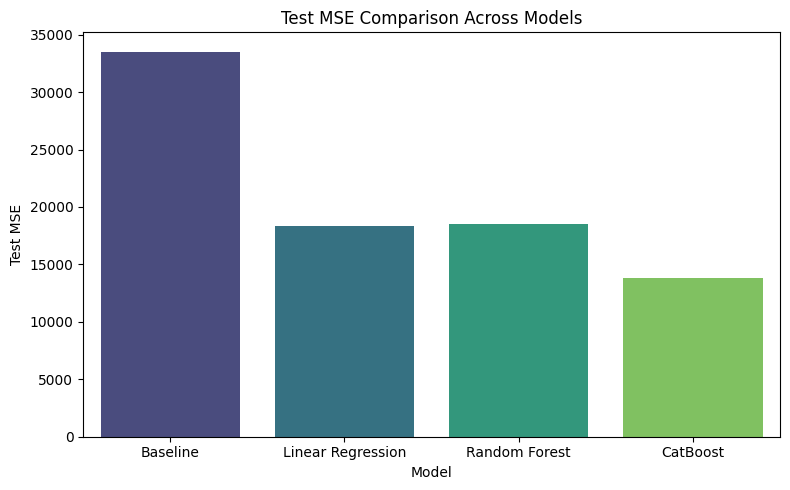

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# If catboost variables aren't defined directly, try to extract the best configuration from results_df.
try:
    cat_train_mse
except NameError:
    if 'results_df' in globals() and not results_df.empty:
        best_cat = results_df.loc[results_df['test_mse'].idxmin()]
        cat_train_mse = best_cat['train_mse']
        cat_test_mse = best_cat['test_mse']
    else:
        raise ValueError("CatBoost results not found. Ensure that Section 5 has been executed properly.")

# Create a DataFrame for model comparison.
results = pd.DataFrame({
    'Model': ['Baseline', 'Linear Regression', 'Random Forest', 'CatBoost'],
    'Train MSE': [baseline_train_mse, lr_train_mse, rfr_train_mse, cat_train_mse],
    'Test MSE': [baseline_test_mse, lr_test_mse, rfr_test_mse, cat_test_mse]
})
print("\nModel Comparison:")
print(results)

# Plot the Test MSE values for visual comparison.
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Test MSE', data=results, palette="viridis")
plt.title('Test MSE Comparison Across Models')
plt.ylabel('Test MSE')
plt.xlabel('Model')
plt.tight_layout()
plt.show()
